## load module

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import random
import json
import os
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy

# pytorch
import torch
from torch import nn
from datasets import Dataset
from transformers import AutoConfig, AutoModel, AutoTokenizer

from autogluon.tabular import TabularDataset, TabularPredictor


import seaborn as sns
import pandas as pd
import numpy as np
import random
import json
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE

############### sklearn ###############
from sklearn.datasets import load_boston, load_diabetes
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from tqdm import tqdm
from nltk.cluster import KMeansClusterer
import nltk
import csv
from datetime import datetime

# pytorch
import torch
from torch import nn
from datasets import Dataset
from transformers import AutoConfig, AutoModel, AutoTokenizer
from torch.utils.tensorboard import SummaryWriter
############### pytorch ###############
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
############### sklearn ###############

from transformers import BertTokenizer, BertModel, AutoAdapterModel, AdapterTrainer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers.adapters import BertAdapterModel, AutoAdapterModel, AdapterArguments
from tokenizers.normalizers import BertNormalizer
from transformers.trainer_utils import get_last_checkpoint
from transformers.modeling_outputs import TokenClassifierOutput

from autogluon.tabular import TabularDataset, TabularPredictor

warnings.filterwarnings('ignore')
np.random.seed(123)
from datasets import load_dataset, Dataset

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    DataCollatorForLanguageModeling,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
    AdamW
)

pd.set_option('mode.chained_assignment', None)
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')
np.random.seed(123)

NOTE: Redirects are currently not supported in Windows or MacOs.


## predict without SteelBERTa

In [2]:
# def load_data(pred_prop='all', seed=666):
#     """
#     Load dataset containing three all properties.
    
#     prop
#         Some selections ['Tensile_value', 'Yield_value', 'Elongation_value', 'all']
#     """
#     data = pd.read_excel('./dataset/temp_plot_modified.xlsx')

#     data['Text_addition'].fillna('', inplace=True)
#     data['Text'] = data['Text'] + ' ' + data['Text_addition']
#     drop_cols = list(data.columns)[0:9] + ['title', 'abstract', 'Other_ele', 'Text_addition', 'Tensile_unit', 'Yield_name'] + \
#         ['H', 'F', 'Na', 'Mg', 'Cl', 'Ca', 'Zn', 'As', 'Zr', 'Y', 'Bi', 'Pb', 'Ta', 'Ce', 'La', 'Sb', 'Zr', 'Fe', 'Sn'] + \
#         ['Elongation_name', 'Elongation_unit', 'Yield_unit']

#     # data.drop(columns=drop_cols, inplace=True)
#     # data.reset_index(drop=True, inplace=True)
        
#     prop_all = ['Tensile_value', 'Yield_value', 'Elongation_value']
#     if pred_prop == 'all':
#         drop_col = []
#     else:
#         drop_col = list(set(prop_all) - set([pred_prop]))

#     data = data.drop(columns=drop_cols+drop_col).copy()
    
#     df_train, df_test = np.split(data.sample(frac=1, random_state=seed, ignore_index=True), [int(.75*len(df))])
#     return df_train, df_test

In [3]:
# metric = 'r2'
# time_min=5

# for p in ['Tensile_value', 'Yield_value', 'Elongation_value']:
#     df_train, df_test = load_data(pred_prop=p)
    
#     df_train, df_test = load_modified_data(pred_prop=p, seed=seed)
#     print(df_train.shape, df_test.shape)
#     train_performance, test_performance = auto_reg(p, df_train, df_test,
#                                                    metric=metric, time_min=time_min)

## utils

In [4]:
def load_modified_data(pred_prop='all', seed=666, split_ratio=0.75):
    """
    Load dataset containing three all properties.
    
    prop
        Some selections ['Tensile_value', 'Yield_value', 'Elongation_value', 'all']
    """
    df = pd.read_csv('./dataset/temp_steelberta_embed.csv', encoding='utf-8')
    df = range_data(df)
    drop_cols = ['Tensile_name', 'Tensile_unit', 'Yield_name', 'Yield_unit'] + \
        ['Elongation_name', 'Elongation_unit', 'Text', 'process_emb']   
    # ['Text', 'process_emb', 'Elongation_name', 'Elongation_unit', '767'] + list(df.columns)[-768:-1]
        
    prop_all = ['Tensile_value', 'Yield_value', 'Elongation_value']
    if pred_prop == 'all':
        drop_col = []
    else:
        drop_col = list(set(prop_all) - set([pred_prop]))
    data = df.drop(columns=drop_cols+drop_col).copy()
 
    for _ in range(50):
        data = data.sample(frac=1.0, random_state=seed)
    
    df_train, df_test = np.split(data.sample(frac=1, random_state=seed, ignore_index=True), [int(split_ratio*len(data))])
    return df_train, df_test

In [5]:
def load_single_data(pred_prop='ts', seed=666):
    """
    Load dataset containing only one property.
    
    prop
        Some selections ['Tensile_value', 'Yield_value', 'Elongation_value', 'all']
    """
    path = f"./dataset/embed_merge_{pred_prop}_all.csv"
    df = pd.read_csv(path, encoding='utf-8')   
    
    
    drop_cols = list(df.columns)[0:5] + ['Other_info', 'Text'] + \
        ['Bi', 'Pb', 'Ta', 'Ce', 'La', 'Sb', 'H', 'F', 'Na', 'Y', 'Pb', 'Fe']
    df.drop(columns=drop_cols, inplace=True)
    
    df_train, df_test = np.split(df.sample(frac=1, random_state=seed, ignore_index=True), [int(.8*len(df))])
    return df_train, df_test

In [6]:
def auto_reg(label, data_train, data_test, metric='r2', time_min=1):
    predictor = TabularPredictor(label=label, eval_metric=metric).fit(data_train, 
                                time_limit=time_min*60, presets='best_quality')
    # add learderboard
    print(predictor.leaderboard(data_test, extra_metrics=['r2'], silent=True))
    
    # performance on training data
    train_performance = predictor.evaluate(data_train, auxiliary_metrics=True)

    train_r2, train_rmse = train_performance['r2'], train_performance['root_mean_squared_error']
    y_train = data_train.loc[:, label]
    y_train_pred = predictor.predict(data_train)
    
    # performance on test data
    test_performance = predictor.evaluate(data_test, auxiliary_metrics=True)
    test_r2, test_rmse = test_performance['r2'], test_performance['root_mean_squared_error']
    y_test = data_test.loc[:, label]
    y_test_pred = predictor.predict(data_test)
    
    ############## plot #########################
    fig = plt.figure(figsize=(10,5), dpi=110)
    
    # on training data
    plt.subplot(121)
    plt.scatter(y_train, y_train_pred, s=15, color='#1F4B73')
    plt.plot(np.arange(0,int(max(y_test)*1.2)), np.arange(0,int(max(y_test)*1.2)), '-', color='#A2555A')
    plt.title(f'Train: $R^2$ = {train_r2}, RMSE={train_rmse}',fontdict={'family':'Times New Roman', 'size': 10})
    plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlim(0,int(max(y_test)*1.2))
    plt.xlim(0,int(max(y_test)*1.2))
    plt.legend(labels=['Train data','Y=X'])
    plt.grid()

    # on test data
    plt.subplot(122)
    plt.scatter(y_test, y_test_pred,s=15 , color='#1F4B73')
    plt.plot(np.arange(0,int(max(y_test)*1.2)), np.arange(0,int(max(y_test)*1.2)), '-', color='#A2555A')
    plt.title(f'Test: $R^2$ = {test_r2}, RMSE={test_rmse}',fontdict={'family':'Times New Roman', 'size': 10})
    plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlim(0,int(max(y_test)*1.2))
    plt.xlim(0,int(max(y_test)*1.2))
    plt.legend(labels=['Test data','Y=X'])
    plt.grid()
    # plt.savefig(f'./mlp_fig/{name}.png')
    return train_performance, test_performance

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def range_data(temp_df, ts_range=[10, 3000], ys_range=[0, 3000], el_range=[5, 150]):
    """
    return value in ranges
    """
    temp_df = temp_df[(temp_df['Tensile_value']>=ts_range[0]) & (temp_df['Tensile_value']<=ts_range[1])]
    temp_df = temp_df[(temp_df['Yield_value']>=ys_range[0]) & (temp_df['Yield_value']<=ys_range[1])]
    temp_df = temp_df[(temp_df['Elongation_value']>=el_range[0]) & (temp_df['Elongation_value']<=el_range[1])]
    temp_df.reset_index(drop=True, inplace=True)
    return temp_df

# model_name = 'bert-base-uncased'
# model_name = 'microsoft/deberta-v3-base'
# model_name = 'm3rg-iitd/matscibert'
model_name = './../model_saved/checkpoint-140000'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddinngs(text_list):
    encoded_input = tokenizer(
        text_list, padding='max_length', max_length = 512, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output).detach().cpu().numpy()[0].tolist()

def gen_text_embed(bert_df, col_embed='Text'):
    """
    return text embeddings
    """
    tqdm.pandas(desc='Progress bar!')
    bert_df['process_emb'] = bert_df[col_embed].progress_apply(get_embeddinngs)

    temp_bert_df = pd.DataFrame(pd.Series(bert_df['process_emb'][0])).T
    for i in range(1, bert_df.shape[0]):
        new_row = pd.DataFrame(pd.Series(bert_df['process_emb'][i])).T
        temp_bert_df = pd.concat([temp_bert_df, new_row], ignore_index=True, axis=0)
    temp_bert_df.reset_index(drop=True, inplace=True)
    temp_bert_df.columns = [col_embed+str(i) for i in range(768)]    
    df = pd.concat([bert_df, temp_bert_df], axis=1)
    df.drop(columns=['process_emb'], inplace=True)
    
    return df

def get_ele_embeddinngs(text_list, ):
    encoded_input = tokenizer(
        text_list, padding='max_length', max_length = 512, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)

    return cls_pooling(model_output).detach().cpu().numpy()

def add_ele_embed(df):
    coms = list(df.columns[3:-770])
    x = np.matrix(get_ele_embeddinngs(coms))
    w1 = list(df.iloc[0, 3:-770])
    y = np.average(x, axis=0, weights=w1)

    for i in np.arange(1, df.shape[0]):        
        w = list(df.iloc[i, 3:-770])
        temp_y = np.average(x, axis=0, weights=w)
        y = np.vstack((y, temp_y))

    ele_df = pd.DataFrame(y, columns=['ele'+str(i) for i in range(768)])
    
    return ele_df

cuda


Some weights of the model checkpoint at ./../model_saved/checkpoint-140000 were not used when initializing DebertaV2Model: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## add actions

In [8]:
# df = pd.read_excel('./datasets/actions_value.xlsx', index_col=None)
# print(df.head(1))

# act_li = []
# rm_string = "[]',"
# for i in range(900):
#     string = ''
#     filt = df['id']==i
#     if len(df[filt]) > 0:        
#         for i in range(len(df[filt])):
#             k = list(df[filt]['action'])
#             v = list(df[filt]['value'])
#             for s in rm_string:
#                 v[i] = v[i].replace(s, '')            
#             # print(kv)
#             string = string + ' ' + k[i] + ' ' + v[i]
#     act_li.append(string)
    
    
# output = pd.DataFrame(act_li)
# print(output.head(1))
# output.to_excel('./datasets/act.xlsx', index=None)

## load data

In [9]:
# label='train_data'
# data_origin = pd.read_excel(f'./datasets/{label}.xlsx')    
# data_origin = range_data(data_origin, ts_range=[10, 3000], ys_range=[0, 3000], el_range=[5, 150])
# com_cols = list(data_origin.columns[17:-4])
# data_origin.head(1)

In [10]:
def load_data(label='train_data', pred_prop='Yield_value', fes=['com', 'text_embed'],
              split_ratio=0.75, seed=42, perplexity=3):
    """
    Loading data
    ===========
    Parameters
    ==========
    label:
        ['train_data', 'text_test', 'exp_test']
        
    pred_prop:    
        ['Tensile_value', 'Yield_value', 'Elongation_value', 'all']        
        
    fes:
        ['com', 'text_embed', 'com_embed', text', 'action_embed']
    
    split_ratio:
        train data : test data
    
    perplexity:
        perplexity of composition TSNE method        
    """
    data_origin = pd.read_excel(f'./datasets/{label}.xlsx')    
    com_cols = set(data_origin.columns[17:-4])

    if label=='train_data':
        data_origin = range_data(data_origin, ts_range=[0, 3000], ys_range=[0, 3000], el_range=[5, 150])
        
        # filter available data
        filter = data_origin['status']==1
        data = data_origin[filter].copy()
        data.reset_index(drop=True, inplace=True)
    else:
        data = data_origin.copy()
    
    # fill composition
    for e_col in com_cols:
        data[e_col].fillna(0.0, inplace=True)  
    # data.iloc[:, 15:-2].fillna(0.0, inplace=True)
    data.fillna('', inplace=True)

    # drop some description cols    
    drop_cols = ['DOIs', 'Files', 'problem', 'status', 'Table_topic', 'title', 'abstract', 'Other_ele', \
                 'Text_addition', 'Tensile_name', 'Tensile_unit', 'Yield_name', 'Yield_unit', \
                 'Elongation_name', 'Elongation_unit', 'Material']
    data.drop(columns=drop_cols, inplace=True)   
    
    # processing text embeddings
    data = gen_text_embed(data)
    
    # composition selection
    # com_drop = ['H', 'F', 'Na', 'Mg', 'Cl', 'Ca', 'Zn', 'As', 'Zr', 'Y', 'Bi', 'Pb', 'Ta',
    #              'Ce', 'La', 'Sb', 'Zr', 'Fe', 'Sn']
    com_drop = ['Fe']
    data.drop(columns=com_drop, inplace=True)
    
    # compostion embeddings
    data = pd.concat([data, add_ele_embed(data)], axis=1)

    # property selection
    prop_all = ['Tensile_value', 'Yield_value', 'Elongation_value']
    if pred_prop == 'all':
        drop_col = []
    else:
        drop_col = list(set(prop_all) - set([pred_prop])) 
        
    # actions embeddings
    data = gen_text_embed(data, col_embed='actions')
        
    # features selection
    if 'com' not in fes:
        drop_col += [col for col in list(data.columns) if col in com_cols]
    if 'text_embed' not in fes:
        drop_col += ['Text'+str(i) for i in range(768)]
    if 'com_embed' not in fes:
        drop_col += ['ele'+str(i) for i in range(768)]    
    if 'action_embed' not in fes:
        drop_col += ['actions'+str(i) for i in range(768)]
    if 'text' not in fes:
        drop_col.append('Text')  
    data.drop(columns=drop_col+['actions'], inplace=True)
    
    if perplexity:
        if 'com_embed' in fes:
            data_com_embed = pd.DataFrame(TSNE(n_components=3, learning_rate='auto',
                              init='random', perplexity=perplexity).fit_transform(data.iloc[:, -768:]), 
                                     columns=['tsne'+str(i) for i in range(3)])
            # data.drop(columns=['ele'+str(i) for i in range(768)], inplace=True)
            data = pd.concat([data, data_com_embed], axis=1)

    if label=='train_data':
        # data shuffle
        for _ in range(50):
            data = data.sample(frac=1.0, random_state=seed)
        # data split
        train_data, test_data = np.split(data.sample(frac=1, random_state=seed, ignore_index=True), [int(split_ratio*len(data))])
        train_data.reset_index(drop=True, inplace=True)
        test_data.reset_index(drop=True, inplace=True)

        return train_data, test_data    
    else:
        return data

In [16]:
train_data, test_data = load_data(label='train_data', pred_prop='Tensile_value', fes=['com', 'text'], seed=42, perplexity=3)
train_data.head(1)

Progress bar!: 100%|███████████████████████████████████| 724/724 [00:19<00:00, 37.53it/s]


,Tensile_value,H,B,C,N,O,F,Na,Mg,Al,Si,P,S,Cl,Ca,Ti,V,Cr,Mn,Co,Ni,Cu,Zn,As,Y,Zr,Nb,Mo,Sn,Sb,La,Ce,Ta,W,Pb,Bi,Text
0,1160.0,0,0.004,0.15,0.02,0.0,0,0,0,0.0,2.0,0.014,0.016,0,0,0.0,0.0,0.68,1.6,0.0,0.0,0.0,0,0,0,0,0.0,0.25,0,0,0,0,0,0.0,0,0,"Ingots were homogenized at 1523 K for 24 hours, followed by forging to ~ 70 × 70 mm2 thick bar. The forged bar was air cooled to room temperature. The chemical composition of the alloys is collate..."


In [ ]:
tqdm.pandas(desc='Progress bar!')
bert_df['process_emb'] = bert_df[col_embed].progress_apply(get_embeddinngs)

In [17]:
def get_len_tokens(text_list):
    encoded_input = tokenizer(text_list)
    return len(encoded_input['input_ids'])

In [19]:
tqdm.pandas(desc='Progress bar!')
train_data['len'] = train_data['Text'].progress_apply(get_len_tokens)
test_data['len'] = test_data['Text'].progress_apply(get_len_tokens)

Progress bar!: 100%|█████████████████████████████████| 181/181 [00:00<00:00, 2792.09it/s]


In [22]:
train_data.to_excel('./temp_train_len.xlsx')
test_data.to_excel('./temp_test_len.xlsx')

In [13]:
# train_data, test_data = load_data(label='train_data', pred_prop='Tensile_value', fes=['com', 'text_embed', 'com_embed', 'action_embed'], seed=42, perplexity=3)
# train_data.head(1)

In [14]:
data = load_data(label='text_test', pred_prop='Tensile_value', fes=['com', 'text_embed', 'com_embed', 'action_embed'], seed=42, perplexity=3)
print(data.shape)
data.head(1)

Progress bar!: 100%|█████████████████████████████████████| 18/18 [00:00<00:00, 23.69it/s]


(18, 2343)


,Tensile_value,H,B,C,N,O,F,Na,Mg,Al,Si,P,S,Cl,Ca,Ti,V,Cr,Mn,Co,Ni,Cu,Zn,As,Y,Zr,Nb,Mo,Sn,Sb,La,Ce,Ta,W,Pb,Bi,Text0,Text1,Text2,Text3,Text4,Text5,Text6,Text7,Text8,Text9,Text10,Text11,Text12,Text13,Text14,Text15,Text16,Text17,Text18,Text19,Text20,Text21,Text22,Text23,Text24,Text25,Text26,Text27,Text28,Text29,Text30,Text31,Text32,Text33,Text34,Text35,Text36,Text37,Text38,Text39,Text40,Text41,Text42,Text43,Text44,Text45,Text46,Text47,Text48,Text49,Text50,Text51,Text52,Text53,Text54,Text55,Text56,Text57,Text58,Text59,Text60,Text61,Text62,Text63,Text64,Text65,Text66,Text67,Text68,Text69,Text70,Text71,Text72,Text73,Text74,Text75,Text76,Text77,Text78,Text79,Text80,Text81,Text82,Text83,Text84,Text85,Text86,Text87,Text88,Text89,Text90,Text91,Text92,Text93,Text94,Text95,Text96,Text97,Text98,Text99,Text100,Text101,Text102,Text103,Text104,Text105,Text106,Text107,Text108,Text109,Text110,Text111,Text112,Text113,Text114,Text115,Text116,Text117,Text118,Text119,Text120,Text121,Text122,Text123,Text124,Text125,Text126,Text127,Text128,Text129,Text130,Text131,Text132,Text133,Text134,Text135,Text136,Text137,Text138,Text139,Text140,Text141,Text142,Text143,Text144,Text145,Text146,Text147,Text148,Text149,Text150,Text151,Text152,Text153,Text154,Text155,Text156,Text157,Text158,Text159,Text160,Text161,Text162,Text163,Text164,Text165,Text166,Text167,Text168,Text169,Text170,Text171,Text172,Text173,Text174,Text175,Text176,Text177,Text178,Text179,Text180,Text181,Text182,Text183,Text184,Text185,Text186,Text187,Text188,Text189,Text190,Text191,Text192,Text193,Text194,Text195,Text196,Text197,Text198,Text199,Text200,Text201,Text202,Text203,Text204,Text205,Text206,Text207,Text208,Text209,Text210,Text211,Text212,Text213,Text214,Text215,Text216,Text217,Text218,Text219,Text220,Text221,Text222,Text223,Text224,Text225,Text226,Text227,Text228,Text229,Text230,Text231,Text232,Text233,Text234,Text235,Text236,Text237,Text238,Text239,Text240,Text241,Text242,Text243,Text244,Text245,Text246,Text247,Text248,Text249,Text250,Text251,Text252,Text253,Text254,Text255,Text256,Text257,Text258,Text259,Text260,Text261,Text262,Text263,Text264,Text265,Text266,Text267,Text268,Text269,Text270,Text271,Text272,Text273,Text274,Text275,Text276,Text277,Text278,Text279,Text280,Text281,Text282,Text283,Text284,Text285,Text286,Text287,Text288,Text289,Text290,Text291,Text292,Text293,Text294,Text295,Text296,Text297,Text298,Text299,Text300,Text301,Text302,Text303,Text304,Text305,Text306,Text307,Text308,Text309,Text310,Text311,Text312,Text313,Text314,Text315,Text316,Text317,Text318,Text319,Text320,Text321,Text322,Text323,Text324,Text325,Text326,Text327,Text328,Text329,Text330,Text331,Text332,Text333,Text334,Text335,Text336,Text337,Text338,Text339,Text340,Text341,Text342,Text343,Text344,Text345,Text346,Text347,Text348,Text349,Text350,Text351,Text352,Text353,Text354,Text355,Text356,Text357,Text358,Text359,Text360,Text361,Text362,Text363,Text364,Text365,Text366,Text367,Text368,Text369,Text370,Text371,Text372,Text373,Text374,Text375,Text376,Text377,Text378,Text379,Text380,Text381,Text382,Text383,Text384,Text385,Text386,Text387,Text388,Text389,Text390,Text391,Text392,Text393,Text394,Text395,Text396,Text397,Text398,Text399,Text400,Text401,Text402,Text403,Text404,Text405,Text406,Text407,Text408,Text409,Text410,Text411,Text412,Text413,Text414,Text415,Text416,Text417,Text418,Text419,Text420,Text421,Text422,Text423,Text424,Text425,Text426,Text427,Text428,Text429,Text430,Text431,Text432,Text433,Text434,Text435,Text436,Text437,Text438,Text439,Text440,Text441,Text442,Text443,Text444,Text445,Text446,Text447,Text448,Text449,Text450,Text451,Text452,Text453,Text454,Text455,Text456,Text457,Text458,Text459,Text460,Text461,Text462,Text463,Text464,Text465,Text466,Text467,Text468,Text469,Text470,Text471,Text472,Text473,Text474,Text475,Text476,Text477,Text478,Text479,Text480,Text481,Text482,Text483,Text484,Text485,Text486,Text487,Text488,Text489,Text490,Text491,Text492,Text493,Text494,Text495,Text496,Text497,Text498,Text499,T

In [13]:
# train_data, test_data = load_data(label='train_data', pred_prop='Yield_value',
#                                     fes=['com', 'text_embed', 'com_embed'], split_ratio=0.75, seed=42, perplexity=3)
# print(train_data.shape, test_data.shape)
# train_data.head(1)

In [14]:
# new_text_data = load_data(label='exp_test', pred_prop='Tensile_value',
#                                     fes=['com', 'text_embed', 'com_embed'], seed=42, perplexity=3)
# print(new_text_data.shape)
# new_text_data.head(1)

In [15]:
# metric = 'r2'
# time_min=3
# p = 'Tensile_value'

# # for p in ['Tensile_value', 'Yield_value', 'Elongation_value']:
# df_train, df_test = load_data(label='train_data', pred_prop=p,
#                                     fes=['text_embed', 'com_embed'], split_ratio=0.75, seed=42, perplexity=3)
# print(df_train.shape, df_test.shape)
# train_performance, test_performance = auto_reg(p, df_train, new_text_data,
#                                                metric=metric, time_min=time_min)

In [16]:
# def compare_datasets(feature):
#     fig, ax = plt.subplots(figsize=(6,4))
#     sns.distplot(df_test[feature], ax=ax, kde=True, hist=False, label='test', kde_kws={'color': 'b', 'lw': 2})
#     sns.distplot(df_train[feature], ax=ax, kde=True, hist=False, label='train', kde_kws={'color': 'g', 'lw': 2})
#     plt.title('Comparison of ' + feature + ' in train and test set')
#     plt.legend();

# interval_cols = list(df_test.columns)[:20]

# for c in interval_cols:
#     compare_datasets(c)

## Pytorch simple

### utils

In [15]:
def set_global_seed(seed=123):
    # for Tensorflow
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.random.set_seed(seed)
        tf.experimental.numpy.random.seed(seed)
        tf.set_random_seed(seed)
        # When running on the CuDNN backend, two further options must be set
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # for PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [16]:
def gen_data_class(df):    

    eles_cols = list(df.columns[1:-2307])
    text_embeds = ['Text'+str(i) for i in range(768)]
    com_embeds = ['ele'+str(i) for i in range(768)]
    com_tsne = ['tsne'+str(i) for i in range(3)]
    action_embeds = ['actions'+str(i) for i in range(768)]
    
    dic = {
        "targets": df.iloc[:, 0],
        "eles": df.loc[:, eles_cols],
        "text_embeds": df.loc[:, text_embeds],
        "com_embeds": df.loc[:, com_embeds],
        "action_embeds": df.loc[:, action_embeds],
        "com_tsne_embeds": df.loc[:, com_tsne]
    }

    return dic

In [17]:
def eval_model(y_true, y_pred):
    """
    Model evaluation for predicted results with "r2" and "rootmean squared error"
    """
    y_true = y_true.detach().cpu().numpy() if torch.is_tensor(y_true) else y_true
    y_pred = y_pred.detach().cpu().numpy() if torch.is_tensor(y_pred) else y_pred

    r2 = round(r2_score(y_true, y_pred), 3)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    mae = round(mean_absolute_error(y_true, y_pred), 3)
    result = {"r2":r2, "rmse":rmse, "mae":mae}
    return result

In [18]:
def plot_test_data(best_new_text_y, best_new_text_preds, text_result,
                   best_exp_y, best_exp_preds, exp_result, labels, fig_name="./outputs/test.png",point_size=10):

    text_val = [text_result['r2'], text_result['rmse'], text_result['mae']]
    exp_val = [exp_result['r2'], exp_result['rmse'], exp_result['mae']]    
    ############## plot #########################
    fig = plt.figure(figsize=(10,5), dpi=120)

    # on new literature data
    y_new_text = best_new_text_y.detach().cpu().numpy()
    y_new_text_pred = best_new_text_preds.detach().cpu().numpy()
    
    # on exp data
    y_exp = best_exp_y.detach().cpu().numpy()
    y_exp_pred = best_exp_preds.detach().cpu().numpy()    

    plt.subplot(121)
    plt.scatter(y_new_text, y_new_text_pred, s=point_size, color='#1F4B73')
    plt.plot(np.arange(int(max(y_new_text)*0.1), int(max(y_new_text)*1.1)), np.arange(int(max(y_new_text)*0.1),int(max(y_new_text)*1.1)), '-', color='#A2555A')
    plt.title(f"$R^2$={text_val[0]}, RMSE={text_val[1]}, MAE={text_val[2]}",
              fontdict={'family':'Times New Roman', 'size': 10})
    plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlim(0, int(max(y_new_text)*1.5))
    plt.ylim(0, int(max(y_new_text)*1.5))
    plt.legend(labels=[labels[0],'Y=X'])
    plt.grid()

    # on new exp data
    plt.subplot(122)
    y_exp = best_exp_y.detach().cpu().numpy()
    y_exp_pred = best_exp_preds.detach().cpu().numpy()
    train_r2 = best_exp_r2

    plt.scatter(y_exp, y_exp_pred, s=point_size, color='#1F4B73')
    plt.plot(np.arange(int(max(y_exp)*0.1), int(max(y_exp)*1.1)), np.arange(int(max(y_exp)*0.1),int(max(y_exp)*1.1)), '-', color='#A2555A')
    plt.title(f"$R^2$={exp_val[0]}, RMSE={exp_val[1]}, MAE={exp_val[2]}",
              fontdict={'family':'Times New Roman', 'size': 10})
    plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
    plt.xlim(0,int(max(y_exp)*1.2))
    plt.ylim(0,int(max(y_exp)*1.2))
    plt.legend(labels=[labels[1],'Y=X'])
    plt.grid()
    
    plt.savefig(fig_name)

### data class

In [19]:
# containging text and ele features for pytorch
class CustomSimpleDataset(Dataset):
    def __init__(self, eles, text_embeds, com_embeds, com_tsne_embeds, action_embeds, targets):
        
        self.eles = eles.values if isinstance(eles, pd.DataFrame) else eles
        self.text_embeds = text_embeds.values if isinstance(text_embeds, pd.DataFrame) else text_embeds
        self.com_embeds = com_embeds.values if isinstance(com_embeds, pd.DataFrame) else com_embeds
        self.com_tsne_embeds = com_tsne_embeds.values if isinstance(com_tsne_embeds, pd.DataFrame) else com_tsne_embeds
        self.action_embeds = action_embeds.values if isinstance(action_embeds, pd.DataFrame) else action_embeds
        self.targets = targets.values if isinstance(targets, pd.DataFrame) else targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            
        ele = self.eles[idx]
        text_embed = self.text_embeds[idx]
        com_embed = self.com_embeds[idx]
        com_tsne_embed = self.com_tsne_embeds[idx]
        action_embed = self.action_embeds[idx]
        target = self.targets[idx]        

        return {
            "labels": torch.tensor(target, dtype=torch.float32).to(device),
            "eles": torch.tensor(ele, dtype=torch.float32).squeeze(0).to(device),
            "text_embeds": torch.tensor(text_embed, dtype=torch.float32).squeeze(0).to(device),
            "com_embeds": torch.tensor(com_embed, dtype=torch.float32).squeeze(0).to(device),
            "action_embeds": torch.tensor(action_embed, dtype=torch.float32).squeeze(0).to(device),
            "com_tsne_embeds": torch.tensor(com_tsne_embed, dtype=torch.float32).squeeze(0).to(device),
        }

In [20]:
###################### CustomSimpleDataset class test
prop = 'Yield_value'
# train_data, test_data = load_data(label='train_data', pred_prop=prop, fes=['com', 'text_embed', 'com_embed', 'action_embed'],
#                                   split_ratio=0.75, seed=42, perplexity=3)
# print(train_data.shape, test_data.shape)

test_data = load_data(label='text_test', pred_prop='Yield_value',
        fes=['com', 'text_embed', 'com_embed', 'action_embed'])
test_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(test_data)),
                                    batch_size=2)
# val_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(train_data)),
#                                     batch_size=2)
# train_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(test_data)),
#                                     batch_size=2)
for batch, s in enumerate(test_dataloader):
    # print(s['embeddings'].shape)
    for k,v in s.items():
        print(k,':', v.shape)
    if batch == 0:
        break

Progress bar!: 100%|█████████████████████████████████████| 18/18 [00:00<00:00, 29.06it/s]


labels : torch.Size([2])
eles : torch.Size([2, 35])
text_embeds : torch.Size([2, 768])
com_embeds : torch.Size([2, 768])
action_embeds : torch.Size([2, 768])
com_tsne_embeds : torch.Size([2, 3])


In [21]:
s

{'labels': tensor([1700., 1980.], device='cuda:0'),
 'eles': tensor([[ 0.0000,  0.0000,  0.0300,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.2700,  0.0000,  0.0500,  0.0000,  0.0000,  0.0370,  0.0000,
          18.0700,  1.5300,  0.0000,  8.1700,  0.3500,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.2300,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0300,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.2700,  0.0000,  0.0500,  0.0000,  0.0000,  0.0370,  0.0000,
          18.0700,  1.5300,  0.0000,  8.1700,  0.3500,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.2300,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]], device='cuda:0'),
 'text_embeds': tensor([[-0.4943,  0.0519, -0.5402,  ..., -0.1088,  0.1600,  0.9149],
         [-0.4205, -0.0464, -0.6503,  ..., -0.1634,  0.0789,  0.8427]],
        device='cuda:0'),
 'com

### pytorch model

In [27]:
class CustomSimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.com_layer = nn.Sequential(
            # nn.LazyLinear(16),
            # nn.ReLU(),
            # nn.LazyLinear(8),
            # nn.ReLU(),
            nn.LazyLinear(4),
            nn.ReLU(),            
        )
        
        self.com_embed_layer = nn.Sequential(

            # nn.LazyLinear(768),
            nn.Linear(768, 256),
            nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
        
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),


        )
        
        self.com_tsne_embed_layer = nn.Sequential(
            nn.LazyLinear(8),
            nn.ReLU(),
            nn.LazyLinear(4),
            nn.ReLU(),
            nn.LazyLinear(4),
            nn.ReLU(),
            nn.LazyLinear(4),
            nn.ReLU(),
            nn.LazyLinear(4),
            nn.ReLU(),
            nn.LazyLinear(2),
            nn.ReLU(),
        )
        
        self.text_embed_layer = nn.Sequential(
                        # nn.LazyLinear(768),
            
            nn.Linear(768, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
#             nn.Linear(256, 256),
#             nn.ReLU(),
            
        
            # nn.Linear(256, 256),
            # nn.ReLU(),
            # nn.Linear(256, 256),
            # nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),           
        )
        self.action_embed_layer = nn.Sequential(
            # nn.Linear(768, 256),
            # nn.ReLU(),
            
            # nn.Dropout(0.1, inplace=False),
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1), nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1), nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Flatten(),
            # nn.LazyLinear(4), nn.ReLU(),
            nn.LazyLinear(4), nn.ReLU()
        )
        
        self.concat_layer = nn.Sequential(
            nn.LazyLinear(786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 786),
            nn.ReLU(),
            nn.Linear(786, 512),
            nn.ReLU(),

            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            
        
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.LazyLinear(32),
            nn.ReLU(),
            nn.LazyLinear(16),
            nn.ReLU(),
            nn.LazyLinear(16),
            nn.ReLU(),
            nn.LazyLinear(8),
            nn.ReLU(),
            nn.LazyLinear(8),
            nn.ReLU(),
            nn.LazyLinear(1)            
        )
        
    def forward(self, eles, text_embeds, com_embeds, com_tsne_embeds, action_embeds, labels):
        # com_embed_output = self.com_embed_layer(com_embeds)
        text_embed_output = self.text_embed_layer(text_embeds)
        com_tsne_embed_output = self.com_tsne_embed_layer(com_tsne_embeds)
        action_embed_output = self.action_embed_layer(action_embeds.unsqueeze(1))
        # ele_output = self.com_layer(eles)

        # output = torch.concat([com_embed_output, text_embed_output, com_tsne_embed_output, ele_output], dim=1)        
        output = torch.concat([com_tsne_embed_output, text_embed_output], dim=1)
        output = self.concat_layer(output)
        
        return output

In [45]:
s['action_embeds'].unsqueeze(1).shape

torch.Size([2, 1, 768])

In [28]:
########### output shape test
test_model = CustomSimpleModel().to(device)
for batch, s in enumerate(test_dataloader):
    # print(s['embeddings'].shape)
    # print(s.keys())
    temp_ouput = test_model(**s)
    print(temp_ouput.shape)
    if batch == 0:
        break

torch.Size([2, 1])


In [29]:
temp_ouput

tensor([[0.1458],
        [0.1458]], device='cuda:0', grad_fn=<AddmmBackward0>)

### training

In [27]:
# train_data[predict_label] = train_data[predict_label] / 100
# test_data[predict_label] = test_data[predict_label] / 100
    
# train_data[predict_label] = train_data[predict_label]  / train_data[predict_label].abs().max() 
# test_data[predict_label] = test_data[predict_label]  / test_data[predict_label].abs().max()

# train_data[predict_label]= np.log(train_data[predict_label])
# test_data[predict_label]= np.log(test_data[predict_label])

In [28]:
with open('./outputs/reg_model.csv', 'a+') as csvfile:  
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['prop', 'train_r2', 'best_val_r2', 'best_new_text_r2', 'best_exp_r2', 'split_ratio', 'train_batch', 'epoch', 'lr', 'step', 'gamma_ratio', 'perplexity', 'seed'])

#### build dataloader

In [29]:
prop = 'Yield_value'
seed = 42
perplexity = 3
split_ratio = 0.75
train_batch = 32

set_global_seed(seed=seed)
paras_string = f"{prop}_{split_ratio}_{train_batch}_{epoch}_{lr}_{step}_{gamma_ratio}_{perplexity}_{seed}"

train_data, test_data = load_data(label='train_data', pred_prop=prop, fes=['com', 'com_embed', 'text_embed', 'action_embed'],
                            split_ratio=split_ratio, seed=seed, perplexity=perplexity)

new_text_data = load_data(label='text_test', pred_prop=prop,
                            fes=['com', 'text_embed', 'com_embed', 'action_embed'], perplexity=perplexity)
exp_data = load_data(label='exp_test', pred_prop=prop,
                            fes=['com', 'text_embed', 'com_embed', 'action_embed'], perplexity=perplexity)

new_text_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(new_text_data)),
                                    batch_size=len(new_text_data))
exp_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(exp_data)),
                                    batch_size=len(exp_data))
all_train_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(train_data)),
                                    batch_size=len(train_data), shuffle=False, drop_last=False)

print(f"train_data.shape:{train_data.shape}, test_data.shape:{test_data.shape}")

train_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(train_data)),
                                    batch_size=train_batch, shuffle=True, drop_last=False)

val_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(test_data)),
                                    batch_size=len(test_data))

Progress bar!: 100%|█████████████████████████████████████| 65/65 [00:01<00:00, 36.83it/s]


train_data.shape:(543, 2326), test_data.shape:(181, 2326)


#### training

In [30]:
lr = 0.001
train_batch = 32
epoch = 150
step = 400
gamma_ratio = 0.1

val_li = []
reg_model = CustomSimpleModel().to(device)
######################## training parameters ############################
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(reg_model.parameters(), lr=lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma_ratio)

# optimizer = torch.optim.LBFGS(params=reg_model.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(reg_model.parameters(), lr=1e-54)

# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=50)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=lr,                                              
#                                                end_factor=1e-4, total_iters=0.8*epoch)


######### TODO: limit total saved models
######################## start training ############################
dt_string = datetime.now().strftime("%d_%m_%H.%M.%S")
writer = SummaryWriter('./outputs/runs', flush_secs=20)

test_r2_li = []
best_val_r2 = -1e5
best_new_text_r2 = -1e5
best_exp_r2 = -1e5

for epoch_num in tqdm(range(epoch)):
    # print(f"\n Epoch {epoch_num+1}\n----------------------------------")
    reg_model.train()
    for batch, inputs in enumerate(train_dataloader):
        
        y = inputs['labels'].unsqueeze(1)
        preds = reg_model(**inputs)
        train_loss = loss_fn(preds, y)
        train_r2 = eval_model(y, preds)['r2']

        # Backpropagation
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 4 == 0:
        #     train_loss, current = train_loss.item(), (batch + 1) * len(y)
        #     print(f"Train batch loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

    scheduler.step()
    # print(f"Train avg r2: {train_r2}, train_loss {train_loss}")

    reg_model.eval()
    # val_loss, val_r2 = 0.0, 0.0
    with torch.no_grad():
        for batch, inputs in enumerate(val_dataloader):
            y = inputs['labels'].unsqueeze(1)
            preds = reg_model(**inputs)
            val_loss = loss_fn(preds, y).item()
            val_r2 = eval_model(y, preds)['r2']

        # text and exp performance on each epoch
        for batch, inputs in enumerate(new_text_dataloader):
            y = inputs['labels'].unsqueeze(1)
            preds = reg_model(**inputs)
            new_text_r2 = eval_model(y, preds)['r2']

        for batch, inputs in enumerate(exp_dataloader):
            y = inputs['labels'].unsqueeze(1)
            preds = reg_model(**inputs)
            exp_r2 = eval_model(y, preds)['r2']

    # plot on tensorboard
    writer.add_scalars('Reg_'+dt_string+'/Loss',
                    tag_scalar_dict = {'train_loss':train_loss,
                                        'val_loss':val_loss},
                    global_step = epoch_num+1)
    writer.add_scalars('Reg_'+dt_string+'/R2',
                        tag_scalar_dict = {'train_r2':train_r2,
                                           'val_r2':val_r2},
                                           # 'test_r2':test_r2},
                        global_step = epoch_num+1)

    writer.add_scalars('Reg_'+dt_string+'/Test_R2',
                    tag_scalar_dict = {'new_text_r2':new_text_r2,
                                        'exp_r2':exp_r2},
                    global_step = epoch_num+1)
    
    # save best model
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(reg_model, f"./outputs/reg_model_saved/{paras_string}.pt")

writer.close()

100%|██████████████████████████████████████████████████| 150/150 [01:41<00:00,  1.48it/s]


#### test validation

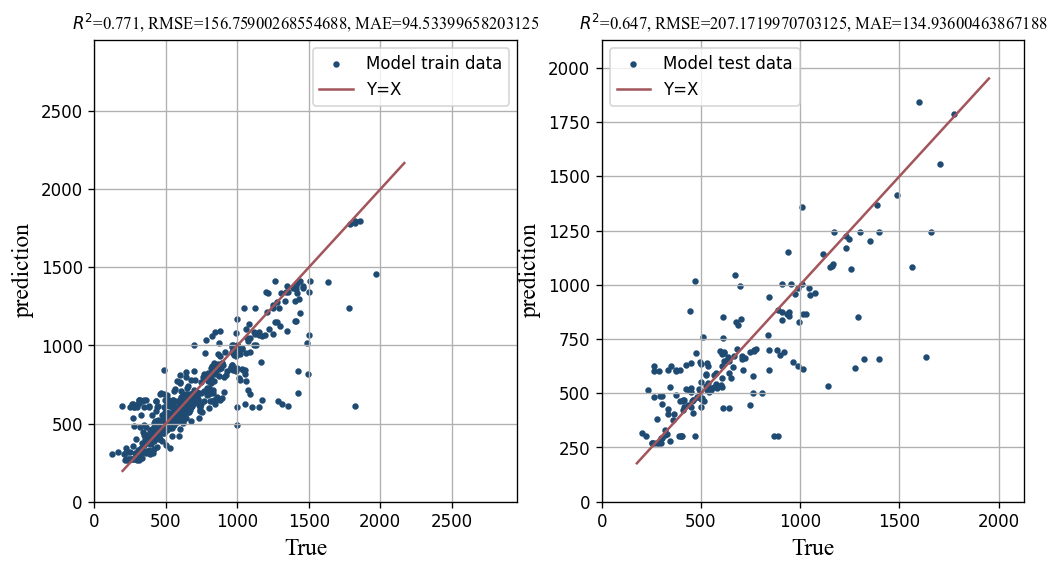

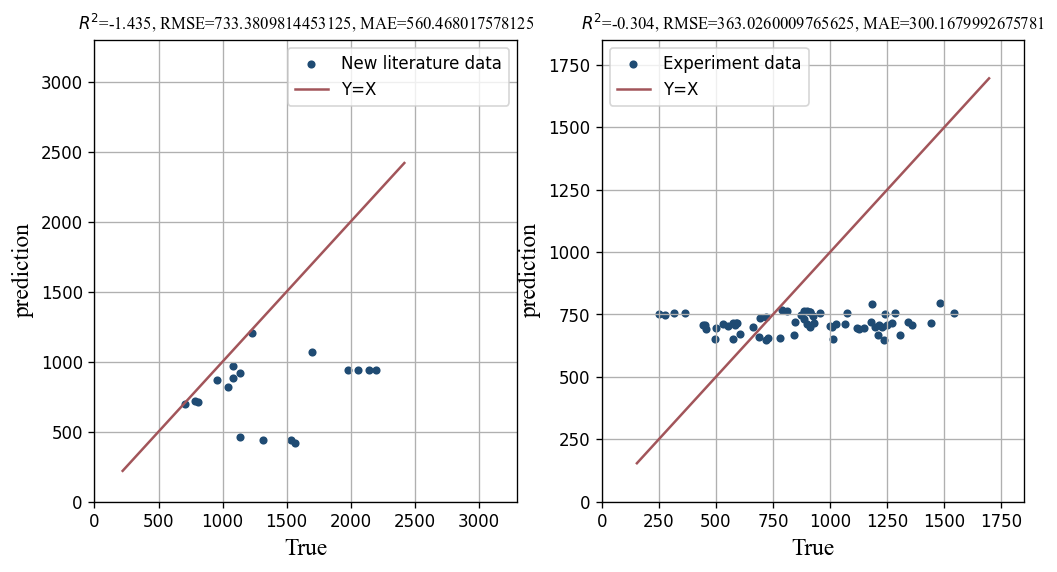

In [32]:
# best_model = CustomSimpleModel().to(device)
# best_model.load_state_dict(torch.load(f"./outputs/reg_model_saved/{paras_string}.pth"))

best_model = torch.load(f"./outputs/reg_model_saved/{paras_string}.pt")

# validate model performance
best_model.eval()
with torch.no_grad():

    for batch, inputs in enumerate(all_train_dataloader):
        y_train = inputs['labels'].unsqueeze(1)
        y_train_preds = best_model(**inputs)        
        train_result = eval_model(y_train, y_train_preds)

    for batch, inputs in enumerate(val_dataloader):
        y_val = inputs['labels'].unsqueeze(1)
        y_val_preds = best_model(**inputs)
        val_result = eval_model(y_val, y_val_preds)

    for batch, inputs in enumerate(new_text_dataloader):
        best_new_text_y = inputs['labels'].unsqueeze(1)
        best_new_text_preds = best_model(**inputs)
        best_new_text_result = eval_model(best_new_text_y, best_new_text_preds)
        
    for batch, inputs in enumerate(exp_dataloader):
        best_exp_y = inputs['labels'].unsqueeze(1)
        best_exp_preds = best_model(**inputs)
        best_exp_result = eval_model(best_exp_y, best_exp_preds)

# performance on 
plot_test_data(y_train, y_train_preds, train_result,
               y_val, y_val_preds, val_result,
               fig_name=f"./outputs/figs/train_{paras_string}.png",
               labels=["Model train data", "Model test data"], point_size=8)

# save new_text and experiment True-Predict figs
plot_test_data(best_new_text_y, best_new_text_preds, best_new_text_result,
               best_exp_y, best_exp_preds, best_exp_result,
               fig_name=f"./outputs/figs/test_{paras_string}.png",
               labels=["New literature data", "Experiment data"], point_size=15)

#### save paras

In [35]:
with open('./outputs/reg_model.csv', 'a+') as csvfile:  
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow([prop, train_result['r2'], val_result['r2'], best_new_text_result['r2'],
        best_exp_result['r2'], split_ratio, train_batch, epoch, lr, step, gamma_ratio, perplexity, seed])

In [136]:
# best_model = CustomSimpleModel().to(device)
# best_model.load_state_dict(torch.load(f"./reg_model_saved/{split_ratio}_{train_batch}_{epoch}_{lr}_{step}_{gamma_ratio}_{perplexity}_{seed}.pth"))

# # new text test
# best_model.eval()
# with torch.no_grad():
#     for batch, inputs in enumerate(new_text_dataloader):
#         best_new_text_y = inputs['labels'].unsqueeze(1)
#         best_new_text_preds = best_model(**inputs)
#         best_new_text_r2 = eval_model(best_new_text_y, best_new_text_preds)['r2']
        
#     for batch, inputs in enumerate(exp_dataloader):
#         best_exp_y = inputs['labels'].unsqueeze(1)
#         best_exp_preds = best_model(**inputs)
#         best_exp_r2 = eval_model(y, preds)['r2']


# #     # experiment test
# #     reg_model.eval()
# #     with torch.no_grad():
# #         for batch, inputs in enumerate(exp_dataloader):
# #             y = inputs['labels'].unsqueeze(1)
# #             preds = reg_model(**inputs)
# #             result = eval_model(y, preds)
# #             exp_r2 = result['r2']       
        
# # # keep best performance on experiment
# # if exp_r2 > best_exp_r2:
# #     best_exp_r2 = exp_r2
# #     best_exp_preds, best_exp_y = preds, y

# # # keep best performance on new text
# # if new_text_r2 > best_new_text_r2:
# #     best_new_text_r2 = new_text_r2
# #     best_new_text_preds, best_new_text_y = preds, y



# # save new_text and experiment True-Predict figs
# plot_test_data(best_new_text_y, best_new_text_preds, best_new_text_r2, best_exp_y,
#                best_exp_preds, best_exp_r2,
#                fig_name=f"./figs/test_{split_ratio}_{train_batch}_{epoch}_{lr}_{step}_{gamma_ratio}_{perplexity}_{seed}.png")

# with open('reg_model.csv', 'a+') as csvfile:  
#     # creating a csv writer object
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow([prop, train_r2, best_val_r2, best_new_text_r2, best_exp_r2, split_ratio, train_batch, epoch, lr, step, gamma_ratio, perplexity, seed])

#### Optimization

In [ ]:
# prop = 'Yield_value'
# # seed = 42
# # perplexity = 3
# # ratio = 0.75

# # for seed in [789]:
    
                            
# for ratio in [0.75, 0.8, 0.7]:
#     for bs in [64, 32, 16]:
#         for epoch in [400]:
#             for lr in [0.01]:
#                 for step in [100, 80, 60, 120]:
#                     for g in [0.1, 0.2, 0.3]:
#                         for perplexity in [3, 2, 5, 8]:
#                             for seed in [789, 123, 456, 666, 42]:
                            
#                                 train_data, test_data = load_data(label='train_data', pred_prop=prop, fes=['com', 'com_embed', 'text_embed'],
#                                                                   split_ratio=ratio, seed=seed, perplexity=perplexity)
#                                 new_text_data = load_data(label='text_test', pred_prop=prop,
#                                                                     fes=['com', 'text_embed', 'com_embed'], seed=seed, perplexity=perplexity)
#                                 exp_data = load_data(label='exp_test', pred_prop=prop,
#                                                                     fes=['com', 'text_embed', 'com_embed'], seed=seed, perplexity=perplexity)

#                                 print(train_data.shape, test_data.shape)

#                                 val_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(test_data)),
#                                                                     batch_size=len(test_data))
#                                 train_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(train_data)),
#                                                                     batch_size=bs, shuffle=True, drop_last=False)
#                                 new_text_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(new_text_data)),
#                                                                     batch_size=len(new_text_data))
#                                 exp_dataloader = DataLoader(CustomSimpleDataset(**gen_data_class(exp_data)),
#                                                                     batch_size=len(exp_data))


#                                 val_li = []
#                                 reg_model = CustomSimpleModel().to(device)
#                                 set_global_seed(seed=seed)
#                                 ######################## training parameters ############################
#                                 # epoch = 100
#                                 # lr = 0.01
#                                 loss_fn = nn.MSELoss()
#                                 optimizer = torch.optim.AdamW(reg_model.parameters(), weight_decay=0.01) # best 3e-4
#                                 # optimizer = torch.optim.LBFGS(params=reg_model.parameters(), lr=lr)

#                                 # optimizer = torch.optim.AdamW(reg_model.parameters(), lr=1e-54)
#                                 # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=50)
#                                 # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=lr,                                              
#                                 #                                                end_factor=1e-4, total_iters=0.8*epoch)
#                                 scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=g)

#                                 ######################## start training ############################
#                                 dt_string = datetime.now().strftime("%d_%m_%Y_%H.%M.%S")
#                                 writer = SummaryWriter('runs', flush_secs=20)

#                                 test_r2_li = []
#                                 best_new_text_r2 = -1e5
#                                 best_exp_r2 = -1e5

#                                 for epoch_num in tqdm(range(epoch)):

#                                     # print(f"\n Epoch {epoch_num+1}\n----------------------------------")
#                                     reg_model.train()
#                                     for batch, inputs in enumerate(train_dataloader):
#                                         y = inputs['labels'].unsqueeze(1)
#                                         # size = len(y)

#                                         preds = reg_model(**inputs)
#                                         train_loss = loss_fn(preds, y)

#                                         result = eval_model(y, preds)
#                                         train_r2 = result['r2']

#                                         # Backpropagation
#                                         train_loss.backward()
#                                         optimizer.step()
#                                         optimizer.zero_grad()

#                                         # if batch % 4 == 0:
#                                         #     train_loss, current = train_loss.item(), (batch + 1) * len(y)
#                                         #     print(f"Train batch loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

#                                     scheduler.step()
#                                     # print(f"Train avg r2: {train_r2}")
#                                     # print(f"train_loss {train_loss}")  

#                                     reg_model.eval()
#                                     num_batches = len(val_dataloader)
#                                     val_loss, val_r2 = 0.0, 0.0
#                                     with torch.no_grad():
#                                         for batch, inputs in enumerate(val_dataloader):

#                                             y = inputs['labels'].unsqueeze(1)
#                                             preds = reg_model(**inputs)
#                                             val_loss = loss_fn(preds, y).item()
#                                             result = eval_model(y, preds)
#                                             val_r2 = result['r2']

#                                     val_loss = val_loss/num_batches
#                                     val_r2 = val_r2/num_batches
#                                     # print(val_loss, val_r2)
#                                     test_r2_li.append(val_r2)

#                                     # new text test
#                                     reg_model.eval()
#                                     with torch.no_grad():
#                                         for batch, inputs in enumerate(new_text_dataloader):
#                                             y = inputs['labels'].unsqueeze(1)
#                                             preds = reg_model(**inputs)
#                                             result = eval_model(y, preds)
#                                             new_text_r2 = result['r2']
#                                     # keep best performance on new text
#                                     if new_text_r2 > best_new_text_r2:
#                                         best_new_text_r2 = new_text_r2
#                                         best_new_text_preds, best_new_text_y = preds, y

#                                     # experiment test
#                                     reg_model.eval()
#                                     with torch.no_grad():
#                                         for batch, inputs in enumerate(exp_dataloader):
#                                             y = inputs['labels'].unsqueeze(1)
#                                             preds = reg_model(**inputs)
#                                             result = eval_model(y, preds)
#                                             exp_r2 = result['r2']
#                                     # keep best performance on experiment
#                                     if exp_r2 > best_exp_r2:
#                                         best_exp_r2 = exp_r2
#                                         best_exp_preds, best_exp_y = preds, y


#                                     # plot on tensorboard
#                                     writer.add_scalars('model_'+dt_string+'/Loss',
#                                                     tag_scalar_dict = {'train_loss':train_loss,
#                                                                         'val_loss':val_loss},
#                                                     global_step = epoch_num+1)
#                                     writer.add_scalars('model_'+dt_string+'/R2',
#                                                         tag_scalar_dict = {'train_r2':train_r2,
#                                                                            'val_r2':val_r2},
#                                                                            # 'test_r2':test_r2},
#                                                         global_step = epoch_num+1)
#                                     writer.add_scalars('model_'+dt_string+'/Test_R2',
#                                                     tag_scalar_dict = {'new_text_r2':new_text_r2,
#                                                                         'exp_r2':exp_r2},
#                                                     global_step = epoch_num+1)


#                                     # test_r2_li.append(test_r2)
#                                 writer.close()
#                                 # print('best val', max(test_r2_li))

#                                 # save new_text and experiment True-Predict figs
#                                 plot_test_data(best_new_text_y, best_new_text_preds, best_new_text_r2, best_exp_y,
#                                                best_exp_preds, best_exp_r2,
#                                                fig_name=f"./figs/test_{ratio}_{bs}_{epoch}_{lr}_{step}_{g}_{perplexity}_{seed}.png")


#                                 with open('reg_model.csv', 'a+') as csvfile:  
#                                     # creating a csv writer object
#                                     csvwriter = csv.writer(csvfile)

#                                     csvwriter.writerow([prop, train_r2, max(test_r2_li), best_new_text_r2, best_exp_r2, ratio, bs, epoch, lr, step, g, perplexity, seed])


In [35]:
# for ratio in [0.75, 0.6, 0.8, 0.7, 0.85]:
#     for bs in [16, 32, 64, 128]:        
#         for epoch in [200, 400, 500, 800, 1000]:
#             for lr in [0.1, 0.01]:
#                 for step in [10, 50, 100, 200]:
#                     for g in [0.1, 0.2, 0.4, 0.6, 0.8]:
#                         for s in [123, 456, 789, 666, 42, 111, 333]:
                            
for ratio in [0.8, 0.75, 0.7]:
    for bs in [64, 636]:
        for epoch in [400, 500, 600]:
            for lr in [0.1]:
                for step in [100]:
                    for g in [0.1, 0.2, 0.4]:
                        for s in [42]:                          
                            
                            train_data, test_data = load_modified_data(pred_prop=predict_label, seed=s, split_ratio=ratio)
                            test_data.reset_index(inplace=True, drop=True)

                            val_dataloader = DataLoader(CustomSimpleDataset(test_data.iloc[:, 1:], test_data.iloc[:, 0]),
                                                                batch_size=len(test_data))
                            train_dataloader = DataLoader(CustomSimpleDataset(train_data.iloc[:, 1:], train_data.iloc[:, 0]),
                                                                batch_size=bs, shuffle=True, drop_last=False)
                            
                            
                            val_li = []
                            set_global_seed(seed=s)
                            reg_model = CustomSimpleModel(model_name).to(device)
                            ######################## training parameters ############################
                            # epoch = 500
                            # lr = 0.01
                            loss_fn = nn.MSELoss()
                            optimizer = torch.optim.AdamW(reg_model.parameters(), weight_decay=0.01) # best 3e-4
                            # optimizer = torch.optim.LBFGS(params=reg_model.parameters(), lr=lr)

                            # optimizer = torch.optim.AdamW(reg_model.parameters(), lr=1e-54)
                            # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=50)
                            # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=lr,                                              
                            #                                                end_factor=1e-4, total_iters=0.8*epoch)
                            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=g)

                            ######################## start training ############################
                            dt_string = datetime.now().strftime("%d_%m_%Y_%H.%M.%S")
                            writer = SummaryWriter('runs', flush_secs=20)
                            test_r2_li = []
                            for epoch_num in tqdm(range(epoch)):
                                # print(f"\n Epoch {epoch_num+1}\n----------------------------------")
                                reg_model.train()
                                for batch, inputs in enumerate(train_dataloader):
                                    y = inputs['labels'].unsqueeze(1)
                                    size = len(y)

                                    preds = reg_model(**inputs)
                                    train_loss = loss_fn(preds, y)

                                    result = eval_model(y, preds)
                                    train_r2 = result['r2']

                                    # Backpropagation
                                    optimizer.zero_grad()
                                    train_loss.backward()        
                                    optimizer.step()


                                    # if batch % 4 == 0:
                                    #     train_loss, current = train_loss.item(), (batch + 1) * len(y)
                                    #     print(f"Train batch loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

                                scheduler.step()
                                # print(f"Train avg r2: {train_r2}")
                                # print(f"train_loss {train_loss}")  

                                reg_model.eval()
                                num_batches = len(val_dataloader)
                                val_loss, val_r2 = 0.0, 0.0
                                with torch.no_grad():
                                    for batch, inputs in enumerate(val_dataloader):

                                        y = inputs['labels'].unsqueeze(1)
                                        preds = reg_model(**inputs)
                                        val_loss = loss_fn(preds, y).item()
                                        result = eval_model(y, preds)
                                        val_r2 = result['r2']

                                val_loss = val_loss/num_batches
                                val_r2 = val_r2/num_batches
                                # print(val_loss, val_r2)
                                test_r2_li.append(val_r2)

                            #     reg_model.eval()
                            #     with torch.no_grad():
                            #         for batch, inputs in enumerate(test_dataloader):
                            #             y = inputs['labels'].unsqueeze(1)
                            #             preds = reg_model(**inputs)
                            #             test_r2 = eval_model(y, preds)['r2']
                            #             print(f"Test r2: {test_r2:>6f}\n")
                            #             print('*'*10)
                            #             print(compute_metrics_for_regression((preds, y)), test_r2)
                            #             print('*'*10)

                                writer.add_scalars('model_'+dt_string+'/Loss',
                                                tag_scalar_dict = {'train_loss':train_loss,
                                                                    'val_loss':val_loss},
                                                global_step = epoch_num+1)
                                writer.add_scalars('model_'+dt_string+'/R2',
                                                    tag_scalar_dict = {'train_r2':train_r2,
                                                                       'val_r2':val_r2},
                                                                       # 'test_r2':test_r2},
                                                    global_step = epoch_num+1)


                                # test_r2_li.append(test_r2)
                            writer.close()
                            
                            print('best val', max(test_r2_li))

                            with open('text_reg.csv', 'a+') as csvfile:  
                                # creating a csv writer object
                                csvwriter = csv.writer(csvfile)
    
                                csvwriter.writerow([train_r2, max(test_r2_li), ratio, bs, epoch, lr, step, g, s])

100%|██████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.35it/s]


best val 0.65483


  2%|█▎                                                 | 10/400 [00:02<01:35,  4.09it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\shaohan.tian\AppData\Local\Temp\ipykernel_41484\434081101.py:56 in <module>             │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\shaohan.tian\\AppData\\Local\\Temp\\ipykernel_41484\\434081101.py'                   │
│                                                                                                  │
│ C:\Users\shaohan.tian\AppData\Local\Temp\ipykernel_41484\2959416053.py:6 in eval_model           │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\shaohan.tian\\AppData\\Local\\Temp\\ipykernel_41484\\2959416053.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

## Training model

In [138]:
metric = 'r2'
predict_label = 'Tensile_value'
time_min=2
seed=666

### prediction from all data

No path specified. Models will be saved in: "AutogluonModels\ag-20231003_083400\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels\ag-20231003_083400\"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    551
Train Data Columns: 786
Label Column: Tensile_value
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1754.0, 338.0, 900.22808, 321.31321)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Ge

(551, 787) (237, 787)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	0.5s = Fit runtime
	786 features in original data used to generate 786 features in processed data.
	Train Data (Processed) Memory Usage: 3.46 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.59s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 119.41s of the 119.4s of remaining time.
	0.4959	 = Vali

                    model  score_test        r2  score_val  pred_time_test  \
0       LightGBMXT_BAG_L1    0.635288  0.635288   0.692860        0.061801   
1         CatBoost_BAG_L1    0.623877  0.623877   0.672763        0.106745   
2     WeightedEnsemble_L2    0.621016  0.621016   0.712814        0.233350   
3  RandomForestMSE_BAG_L1    0.617522  0.617522   0.697778        0.057844   
4    ExtraTreesMSE_BAG_L1    0.615925  0.615925   0.697932        0.048867   
5         LightGBM_BAG_L1    0.607548  0.607548   0.692164        0.041889   
6   KNeighborsDist_BAG_L1    0.577488  0.577488   0.667210        0.019952   
7   KNeighborsUnif_BAG_L1    0.410536  0.410536   0.495934        0.019946   

   pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.036901  10.052151                 0.061801                0.036901   
1       0.085771  64.660124                 0.106745                0.085771   
2       0.317207  28.650019                 0.002996     

Evaluation: r2 on test data: 0.9722741867645204
Evaluations on test data:
{
    "r2": 0.9722741867645204,
    "root_mean_squared_error": -53.45351570998836,
    "mean_squared_error": -2857.2783417579726,
    "mean_absolute_error": -34.22054466311252,
    "pearsonr": 0.9888731188541418,
    "median_absolute_error": -20.923583984375
}
Evaluation: r2 on test data: 0.6210159391095018
Evaluations on test data:
{
    "r2": 0.6210159391095018,
    "root_mean_squared_error": -193.8907104353653,
    "mean_squared_error": -37593.60759313067,
    "mean_absolute_error": -127.22601882355121,
    "pearsonr": 0.7965807530744673,
    "median_absolute_error": -72.12432861328125
}


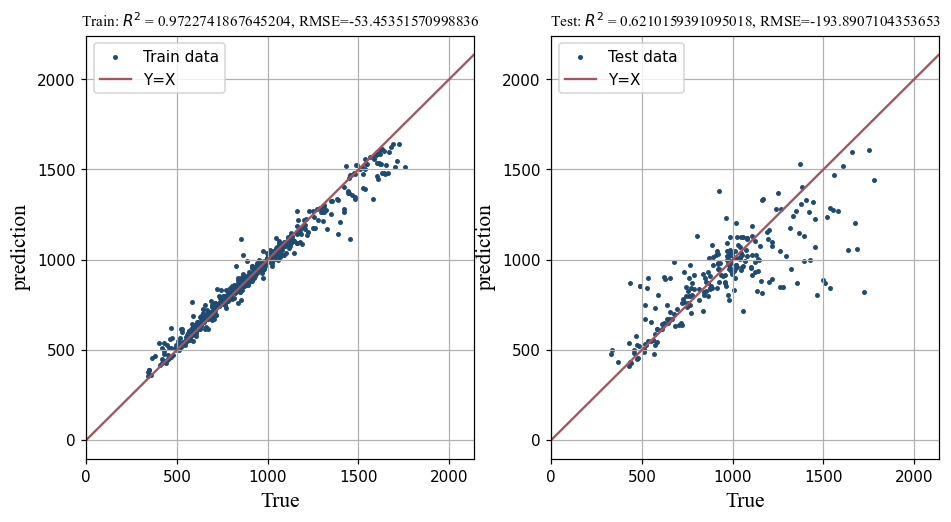

In [142]:
df_train, df_test = load_modified_data(pred_prop=predict_label, seed=seed)
print(df_train.shape, df_test.shape)
train_performance, test_performance = auto_reg(predict_label, df_train, df_test,
                                               metric=metric, time_min=time_min)

# for seed in [666, 123, 456, 789, 555]:
#     df_train, df_test = load_modified_data(pred_prop=predict_label, seed=seed)
#     print(df_train.shape, df_test.shape)
#     train_performance, test_performance = auto_reg(predict_label, df_train, df_test,
#                                                    metric=metric, time_min=time_min)

No path specified. Models will be saved in: "AutogluonModels\ag-20231003_081824\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=6, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels\ag-20231003_081824\"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    609
Train Data Columns: 786
Label Column: Elongation_value
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (108.0, 1.3, 26.63312, 18.48582)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Gene

(609, 787) (262, 787)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	0.5s = Fit runtime
	786 features in original data used to generate 786 features in processed data.
	Train Data (Processed) Memory Usage: 3.83 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.59s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 119.4s of the 119.4s of remaining time.
	0.5666	 = Valid

                    model  score_test        r2  score_val  pred_time_test  \
0       LightGBMXT_BAG_L1    0.716260  0.716260   0.683956        0.131645   
1         LightGBM_BAG_L1    0.715351  0.715351   0.651575        0.068816   
2     WeightedEnsemble_L2    0.709211  0.709211   0.700717        0.213427   
3  RandomForestMSE_BAG_L1    0.703888  0.703888   0.666528        0.058842   
4    ExtraTreesMSE_BAG_L1    0.694801  0.694801   0.666585        0.048870   
5   KNeighborsDist_BAG_L1    0.675583  0.675583   0.669193        0.020946   
6         CatBoost_BAG_L1    0.603003  0.603003   0.588907        0.125664   
7   KNeighborsUnif_BAG_L1    0.566426  0.566426   0.566565        0.020945   

   pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.065825  36.627203                 0.131645                0.065825   
1       0.038904  32.063301                 0.068816                0.038904   
2       0.205481  41.027490                 0.001994     

Evaluation: r2 on test data: 0.9875804166118126
Evaluations on test data:
{
    "r2": 0.9875804166118126,
    "root_mean_squared_error": -2.0584260787637567,
    "mean_squared_error": -4.237117921734736,
    "mean_absolute_error": -1.1655454807563368,
    "pearsonr": 0.9945292768689452,
    "median_absolute_error": -0.6158008575439453
}
Evaluation: r2 on test data: 0.7092114707895796
Evaluations on test data:
{
    "r2": 0.7092114707895796,
    "root_mean_squared_error": -10.407317129143335,
    "mean_squared_error": -108.31224982656026,
    "mean_absolute_error": -6.641979476841352,
    "pearsonr": 0.8423640136703959,
    "median_absolute_error": -3.8094555854797356
}


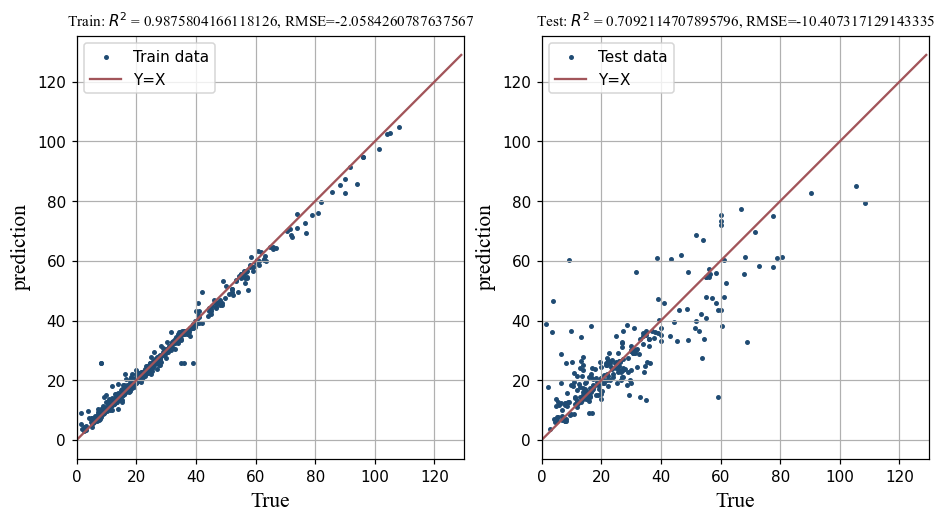

In [122]:
df_train, df_test = load_modified_data(pred_prop='Elongation_value', seed=seed)
print(df_train.shape, df_test.shape)
train_performance, test_performance = auto_reg('Elongation_value', df_train, df_test,
                                               metric=metric, time_min=time_min)

No path specified. Models will be saved in: "AutogluonModels\ag-20231003_082027\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=6, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "AutogluonModels\ag-20231003_082027\"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    609
Train Data Columns: 786
Label Column: Yield_value
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2155.0, 120.0, 700.40493, 349.276)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Genera

(609, 787) (262, 787)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	0.5s = Fit runtime
	786 features in original data used to generate 786 features in processed data.
	Train Data (Processed) Memory Usage: 3.83 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.6s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 119.4s of the 119.4s of remaining time.
	0.4373	 = Valida

                    model  score_test        r2  score_val  pred_time_test  \
0  RandomForestMSE_BAG_L1    0.455565  0.455565   0.590144        0.072806   
1         LightGBM_BAG_L1    0.452411  0.452411   0.558281        0.123670   
2     WeightedEnsemble_L2    0.444777  0.444777   0.621245        0.345078   
3       LightGBMXT_BAG_L1    0.444294  0.444294   0.571171        0.124665   
4   KNeighborsDist_BAG_L1    0.408334  0.408334   0.602967        0.019947   
5   KNeighborsUnif_BAG_L1    0.286180  0.286180   0.437250        0.021914   
6         CatBoost_BAG_L1    0.059774  0.059774   0.069429        0.132646   

   pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.111703    4.300503                 0.072806                0.111703   
1       0.052861   63.403582                 0.123670                0.052861   
2       0.250338  103.711823                 0.003990                0.000000   
3       0.056851   35.784336                 0.1246

Evaluation: r2 on test data: 0.984544349895683
Evaluations on test data:
{
    "r2": 0.984544349895683,
    "root_mean_squared_error": -43.38659069576202,
    "mean_squared_error": -1882.396252201583,
    "mean_absolute_error": -25.127833882349073,
    "pearsonr": 0.9940242388944209,
    "median_absolute_error": -14.203112792968739
}
Evaluation: r2 on test data: 0.4447765663889839
Evaluations on test data:
{
    "r2": 0.4447765663889839,
    "root_mean_squared_error": -256.10874456494093,
    "mean_squared_error": -65591.68904263017,
    "mean_absolute_error": -153.12694160752622,
    "pearsonr": 0.6693227023235147,
    "median_absolute_error": -79.96788024902344
}


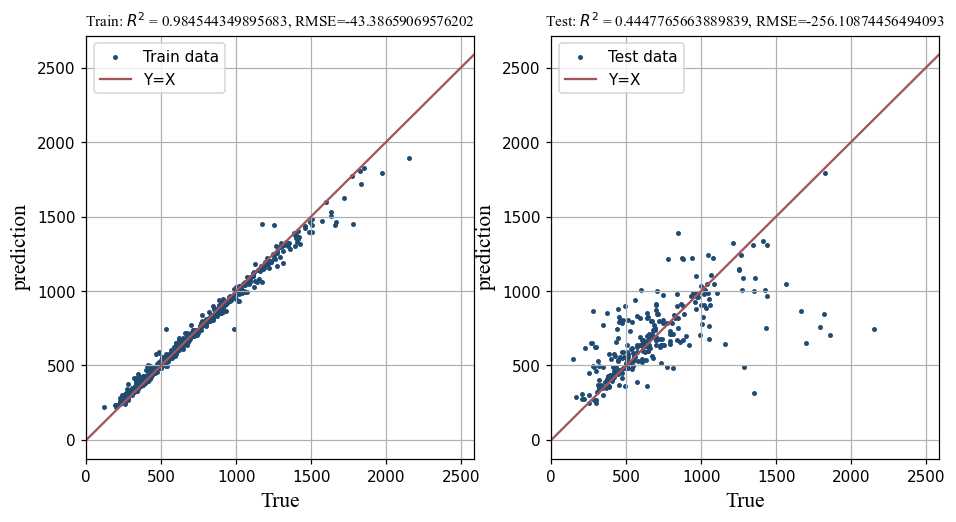

In [123]:
df_train, df_test = load_modified_data(pred_prop='Yield_value', seed=seed)
print(df_train.shape, df_test.shape)
train_performance, test_performance = auto_reg('Yield_value', df_train, df_test,
                                               metric=metric, time_min=time_min)

In [178]:

# ['Tensile_value', 'Yield_value', 'Elongation_value', 'all']


# for seed in [666]:
#     for p in ['Tensile_value', 'Yield_value', 'Elongation_value']:
#         df_train, df_test = load_modified_data(pred_prop=p, seed=seed)
#         print(df_train.shape, df_test.shape)
#         # df_train, df_test = load_data(pred_prop=predict_label, seed=666)
#         train_performance, test_performance = auto_reg(p, df_train, df_test, metric=metric, time_min=time_min)

### prediction from single data

No path specified. Models will be saved in: "AutogluonModels\ag-20231001_165610\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels\ag-20231001_165610\"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    9642
Train Data Columns: 793
Label Column: Property_value
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2470.0, 0.0, 801.28671, 400.47727)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature G

(9642, 794) (2411, 794)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	1.2s = Fit runtime
	793 features in original data used to generate 793 features in processed data.
	Train Data (Processed) Memory Usage: 61.17 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 1.29s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 2398.5

                     model  score_test  score_val  pred_time_test  \
0      WeightedEnsemble_L3    0.708673   0.826934       33.279298   
1        LightGBMXT_BAG_L1    0.708133   0.683650        0.296180   
2          CatBoost_BAG_L2    0.707099   0.705261       30.095972   
3        LightGBMXT_BAG_L2    0.706708   0.825696       32.757827   
4     LightGBMLarge_BAG_L1    0.706097   0.678801        0.248336   
5          CatBoost_BAG_L1    0.705488   0.681476        0.183509   
6      WeightedEnsemble_L2    0.704796   0.691813        2.807267   
7     ExtraTreesMSE_BAG_L2    0.704674   0.797853       30.178588   
8          LightGBM_BAG_L1    0.703703   0.682996        0.248336   
9          LightGBM_BAG_L2    0.703001   0.804249       31.488221   
10          XGBoost_BAG_L1    0.702711   0.676175        0.930511   
11  RandomForestMSE_BAG_L2    0.701997   0.792668       30.185704   
12  RandomForestMSE_BAG_L1    0.693720   0.680713        0.163563   
13  NeuralNetFastAI_BAG_L1    0.68

Evaluation: r2 on test data: 0.7979303510162765
Evaluations on test data:
{
    "r2": 0.7979303510162765,
    "root_mean_squared_error": -180.01383705519436,
    "mean_squared_error": -32404.98153133407,
    "mean_absolute_error": -107.16076820640761,
    "pearsonr": 0.8935042109746456,
    "median_absolute_error": -53.47834289550781
}
Evaluation: r2 on test data: 0.7086725818349389
Evaluations on test data:
{
    "r2": 0.7086725818349389,
    "root_mean_squared_error": -220.18877940580802,
    "mean_squared_error": -48483.098576219585,
    "mean_absolute_error": -137.76017507359532,
    "pearsonr": 0.84192840210211,
    "median_absolute_error": -78.9783935546875
}
No path specified. Models will be saved in: "AutogluonModels\ag-20231001_180235\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels\ag-20231001_18023

(8234, 794) (2059, 794)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	0.9s = Fit runtime
	793 features in original data used to generate 793 features in processed data.
	Train Data (Processed) Memory Usage: 52.24 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 0.97s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 2398.7

                     model    score_test  score_val  pred_time_test  \
0           XGBoost_BAG_L1  5.851236e-01  -0.000121        0.782906   
1    KNeighborsDist_BAG_L1  4.689626e-01  -0.059259        0.434841   
2    KNeighborsUnif_BAG_L1  2.614805e-01  -0.200146        0.386963   
3           XGBoost_BAG_L2  1.096457e-01  -0.000121        1.900967   
4    NeuralNetTorch_BAG_L2 -3.807880e-03  -0.000121        1.633883   
5      WeightedEnsemble_L3 -3.807880e-03  -0.000121        1.635877   
6    NeuralNetTorch_BAG_L1 -1.102240e-02  -0.000121        0.594413   
7        LightGBMXT_BAG_L2 -2.438447e+19  -0.000337        1.205826   
8        LightGBMXT_BAG_L1 -2.653365e+19  -0.000433        0.160542   
9          LightGBM_BAG_L2 -3.063358e+19  -0.000330        1.205825   
10         LightGBM_BAG_L1 -3.190425e+19  -0.000359        0.156581   
11    LightGBMLarge_BAG_L2 -1.162069e+20  -0.000320        1.234748   
12         CatBoost_BAG_L1 -2.112803e+20  -0.000147        0.139655   
13    

Evaluation: r2 on test data: -0.00012146240738819536
Evaluations on test data:
{
    "r2": -0.00012146240738819536,
    "root_mean_squared_error": -6552987741977940.0,
    "mean_squared_error": -4.294164834651314e+31,
    "mean_absolute_error": -72216082275237.47,
    "pearsonr": -0.007058441724720348,
    "median_absolute_error": -449.3779983520508
}
Evaluation: r2 on test data: -0.0038078796572575957
Evaluations on test data:
{
    "r2": -0.0038078796572575957,
    "root_mean_squared_error": -15935.88595228678,
    "mean_squared_error": -253952461.08429116,
    "mean_absolute_error": -987.67212670333,
    "pearsonr": 0.003120569350676726,
    "median_absolute_error": -449.31177520751953
}
No path specified. Models will be saved in: "AutogluonModels\ag-20231001_190016\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "Autoglu

(5828, 794) (1457, 794)


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 793 | ['B', 'C', 'N', 'O', 'Mg', ...]
	0.8s = Fit runtime
	793 features in original data used to generate 793 features in processed data.
	Train Data (Processed) Memory Usage: 36.97 MB (0.1% of available memory)
Data preprocessing and feature engineering runtime = 0.86s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric parameter of Predictor()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 2398.8

                     model  score_test  score_val  pred_time_test  \
0          CatBoost_BAG_L1    0.502088   0.471786        0.158575   
1           XGBoost_BAG_L1    0.501860   0.466472        0.559502   
2        LightGBMXT_BAG_L1    0.499699   0.479222        0.156581   
3          LightGBM_BAG_L1    0.498951   0.481666        0.134640   
4     LightGBMLarge_BAG_L1    0.498055   0.470373        0.145610   
5      WeightedEnsemble_L2    0.487871   0.469005        0.424501   
6   NeuralNetFastAI_BAG_L2    0.485134   0.454716       17.294037   
7   RandomForestMSE_BAG_L1    0.482244   0.462925        0.093750   
8          CatBoost_BAG_L2    0.481424   0.710082        1.332100   
9           XGBoost_BAG_L2    0.478979   0.714511        1.862654   
10    ExtraTreesMSE_BAG_L1    0.477559   0.462358        0.078786   
11     WeightedEnsemble_L3    0.477359   0.772245        2.868936   
12  NeuralNetFastAI_BAG_L1    0.475753   0.392174       15.913778   
13       LightGBMXT_BAG_L2    0.47

Evaluation: r2 on test data: 0.5710238788223809
Evaluations on test data:
{
    "r2": 0.5710238788223809,
    "root_mean_squared_error": -12.36954035724683,
    "mean_squared_error": -153.00552864955804,
    "mean_absolute_error": -7.142226612587169,
    "pearsonr": 0.7573187197019233,
    "median_absolute_error": -3.8758744239807115
}
Evaluation: r2 on test data: 0.4773590951932769
Evaluations on test data:
{
    "r2": 0.4773590951932769,
    "root_mean_squared_error": -13.400815362257259,
    "mean_squared_error": -179.58185237331014,
    "mean_absolute_error": -8.558568914114323,
    "pearsonr": 0.6981457202403827,
    "median_absolute_error": -5.214305877685547
}


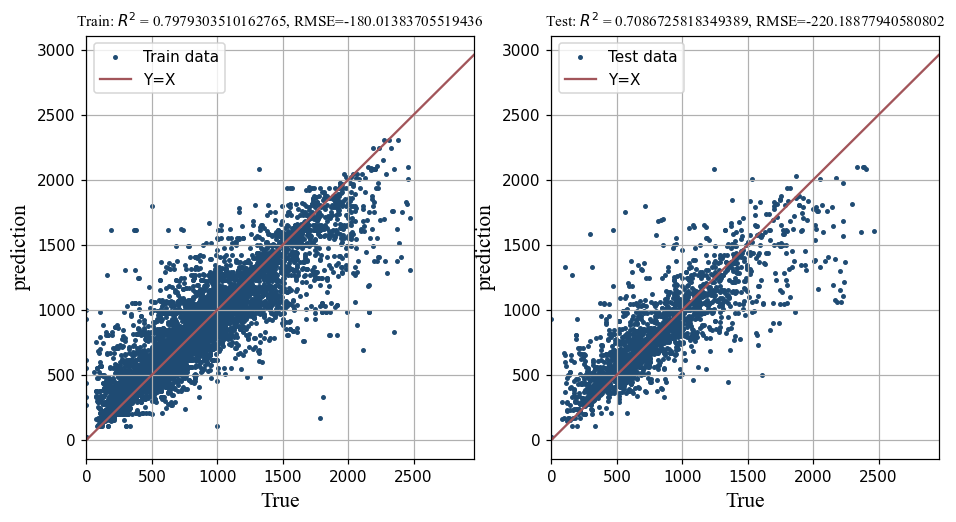

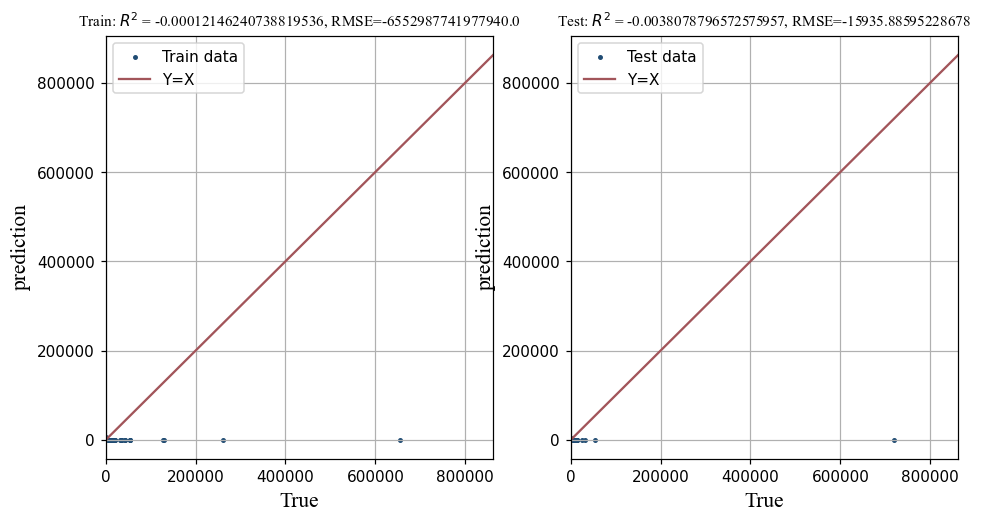

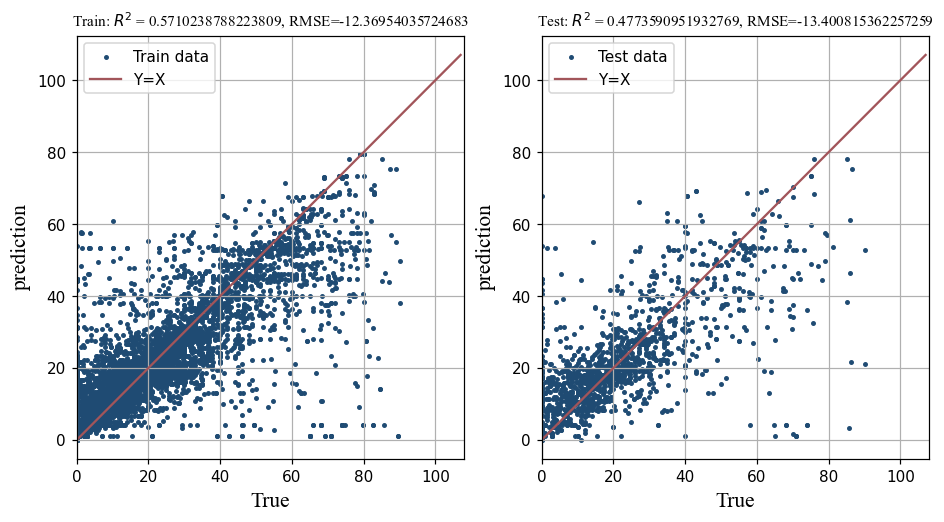

In [140]:
# metric = 'r2'
# predict_label = 'Property_value'
# time_min=3

for p in ['ts', 'ys', 'el']:
    df_train, df_test = load_single_data(pred_prop=p, seed=666)
    print(df_train.shape, df_test.shape)
    # df_train, df_test = load_data(pred_prop=predict_label, seed=666)
    train_performance, test_performance = auto_reg('Property_value', df_train, df_test, metric=metric, time_min=time_min)

In [141]:
# df_train, df_test = load_data(pred_prop='Tensile_value', seed=666)

# save_path = "tab_num_text"
# # metric = 'root_mean_squared_error'
# metric = 'r2'
# predict_label = 'Tensile_value'
# # 这里可以适当增加time_limit限制使模型更优
# predictor_potential = TabularPredictor(label=predict_label, path=save_path,  
#     eval_metric=metric).fit(df_train, time_limit=10*60, presets='best_quality',
# )

# # performance = predictor_potential.evaluate(df_test) # 测试集上的表现

# predictor_potential.leaderboard(df_test, silent=True)

In [142]:
# # performance on training data
# train_performance = predictor_potential.evaluate(df_train, auxiliary_metrics=True)

# train_r2, train_rmse = train_performance['r2'], train_performance['root_mean_squared_error']
# y_train = df_train.loc[:, 'Tensile_value']
# y_train_pred = predictor_potential.predict(df_train)

In [143]:
# # performance on test data
# test_performance = predictor_potential.evaluate(df_test, auxiliary_metrics=True) # 测试集上的表现

# test_r2, test_rmse = test_performance['r2'], test_performance['root_mean_squared_error']
# y_test = df_test.loc[:, 'Tensile_value']
# y_test_pred = predictor_potential.predict(df_test)

In [21]:
# fig = plt.figure(figsize=(10,5), dpi=110)

# # on training data
# plt.subplot(121)
# plt.scatter(y_train, y_train_pred, s=5, color='#1F4B73')
# plt.plot(np.arange(0,2500), np.arange(0,2500), '-', color='#A2555A')
# plt.title(f'Train: $R^2$ = {train_r2}, RMSE={train_rmse}',fontdict={'family':'Times New Roman', 'size': 10})
# plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
# plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
# plt.xlim(0,2500)
# plt.xlim(0,2500)
# plt.legend(labels=['Train data','Y=X'])
# plt.grid()

# # on test data
# plt.subplot(122)
# plt.scatter(y_test, y_test_pred,s=5 , color='#1F4B73')
# plt.plot(np.arange(0,2500), np.arange(0,2500), '-', color='#A2555A')
# plt.title(f'Test: $R^2$ = {test_r2}, RMSE={test_rmse}',fontdict={'family':'Times New Roman', 'size': 10})
# plt.ylabel('prediction', fontdict={'family':'Times New Roman', 'size': 14})
# plt.xlabel('True', fontdict={'family':'Times New Roman', 'size': 14})
# plt.xlim(0,2500)
# plt.xlim(0,2500)
# plt.legend(labels=['Test data','Y=X'])
# plt.grid()
# # plt.savefig(f'./mlp_fig/{name}.png')

### Multiple ColumnsMultiple regression

#### Multilabel reg

In [22]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

#### Training

In [23]:
df_train, df_test = load_modified_data(pred_prop='all', seed=666)

labels = ['Tensile_value','Yield_value','Elongation_value']  # which columns to predict based on the others
problem_types = ['regression','regression','regression']  # type of each prediction problem (optional)
eval_metrics = ['r2','r2','r2']  # metrics used to evaluate predictions for each label (optional)
presets = ['best_quality', 'best_quality', 'best_quality']
save_path = 'agModels-predictEducationClass'  # specifies folder to store trained models (optional)

time_limit = 30  # how many seconds to train the TabularPredictor for each label, set much larger in your applications!

In [24]:
multi_predictor = MultilabelPredictor(labels=labels, problem_types=problem_types, eval_metrics=eval_metrics, 
                                      path=save_path)
multi_predictor.fit(df_train, time_limit=time_limit*60, presets=presets)

Presets specified: ['best_quality', 'best_quality', 'best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "agModels-predictEducationClass\Predictor_Tensile_value\"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    450
Train Data Columns: 789
Label Column: Tensile_value
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    29759.35 MB
	Train Data (Original)  Memory Usage: 2.84 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.


Fitting TabularPredictor for label: Tensile_value ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 3): ['Mg', 'Cl', 'Zn']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 786 | ['B', 'C', 'N', 'O', 'Al', ...]
	0.5s = Fit runtime
	786 features in original data used to generate 786 features in processed data.
	Train Data (Processed) Memory Usage: 2.83 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.57s ...
AutoGluon will ga

Fitting TabularPredictor for label: Yield_value ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 3): ['Mg', 'Cl', 'Zn']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 787 | ['Tensile_value', 'B', 'C', 'N', 'O', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 787 | ['Tensile_value', 'B', 'C', 'N', 'O', ...]
	0.5s = Fit runtime
	787 features in original data used to generate 787 features in processed data.
	Train Data (Processed) Memory Usage: 2.83 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.56s

Fitting TabularPredictor for label: Elongation_value ...


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Useless Original Features (Count: 3): ['Mg', 'Cl', 'Zn']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 788 | ['Tensile_value', 'Yield_value', 'B', 'C', 'N', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 788 | ['Tensile_value', 'Yield_value', 'B', 'C', 'N', ...]
	0.5s = Fit runtime
	788 features in original data used to generate 788 features in processed data.
	Train Data (Processed) Memory Usage: 2.84 MB (0.0% of available memory)
Data preprocessing and feature enginee

#### Evaluation

In [ ]:
evaluations = multi_predictor.evaluate(df_test)
print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)